<a href="https://colab.research.google.com/github/nadyaloseva/ML_itmo/blob/main/%D0%9C%D0%B0%D1%88_%D0%BE%D0%B1%D1%83%D1%87_%D0%BB%D0%B0%D0%B15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [3]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [1]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [4]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



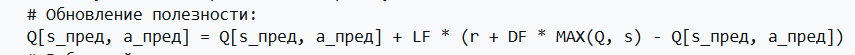

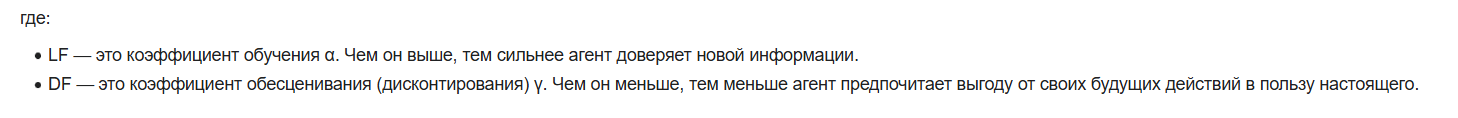

Ссылка на формулу: https://ru.wikipedia.org/wiki/Q-обучение

In [5]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2,:]) - Q[state, action])


В итоге при обновлении значения функции ценности действий мы опираемся не на выбранную стратегию, а на оптимальную, но на следующем шаге, т.е `максимизировать суммарную награду в долгосрочной перспективе`

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [7]:
from tqdm import tqdm

# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
wins_in_a_row = 0
total_wins = 0
game_of_fifth_win = None

#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        t += 1
        action = choose_action(state) # выбираем действие
        state2, reward, done, info = env.step(action)
        if t == max_steps:
            done = True
        learn(state, state2, reward, action, done)
        state = state2
        if done:
            if reward > 0:  # if it's a win
                total_wins += 1
                wins_in_a_row += 1
                if wins_in_a_row == 5 and game_of_fifth_win is None:
                    game_of_fifth_win = game + 1
            else:
                wins_in_a_row = 0  # reset the wins in a row counter if the agent didn't win
            break

100%|██████████| 10000/10000 [00:07<00:00, 1376.51it/s]


Вывод ответов при заданных параметрах

In [8]:
print("Количество побед в серии из 10 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", game_of_fifth_win)

Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [9]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

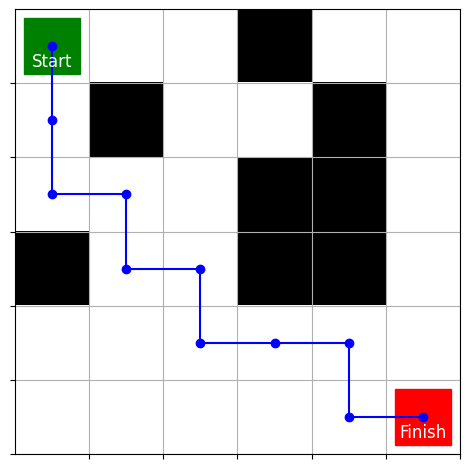

In [10]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



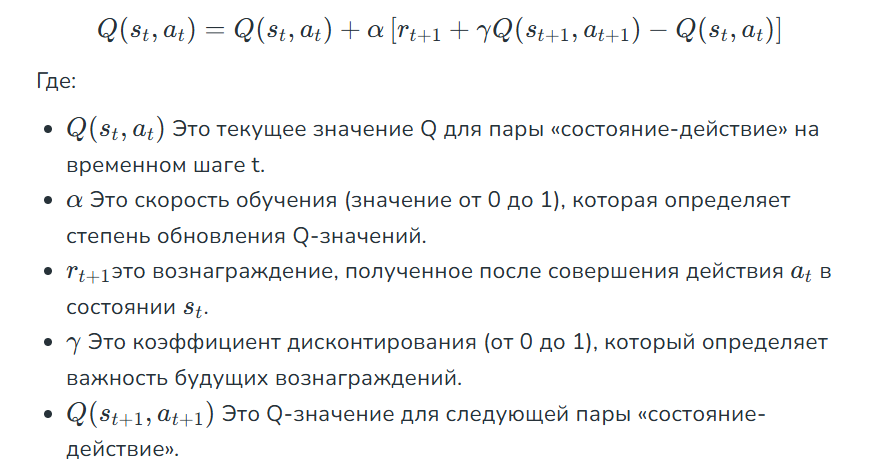

In [11]:
# Функция обновления Q-значений в SARSA
def learn(state, state2, reward, action, action2, done):
    current_q = Q[state, action]
    next_q = Q[state2, action2] if not done else 0  # SARSA использует следующее действие, а не max Q
    Q[state, action] = current_q + lr_rate * (reward + gamma * next_q - current_q)


В SARSA агент учится на основе действий, которые он фактически выполняет, в отличие от Q-обучения,

In [12]:
from tqdm import tqdm
np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
wins_in_a_row = 0
total_wins = 0
game_of_fifth_win = None

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state)  # Выбор действия в самом начале каждой игры

    while t < max_steps:
        t += 1

        state2, reward, done, info = env.step(action)

        action2 = choose_action(state2)  # Выбор следующего действия

        if t == max_steps:
            done = True

        learn(state, state2, reward, action, action2, done)  # Передаем action2 в функцию обучения

        state = state2
        action = action2

        if done:
            if reward > 0:  # if it's a win
                total_wins += 1
                wins_in_a_row += 1
                if wins_in_a_row == 5 and game_of_fifth_win is None:
                    game_of_fifth_win = game + 1
            else:
                wins_in_a_row = 0  # reset the wins in a row counter if the agent didn't win
            break

100%|██████████| 40000/40000 [00:42<00:00, 939.58it/s] 


In [13]:
print("Количество побед в серии из 10 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", game_of_fifth_win)

Количество побед в серии из 10 000 игр:  32328
Пять побед подряд впервые было одержано в игре  894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

# Базовая часть

 Исследуйте влияние параметров gamma, lr_rate, epsilon на обучение моделей. Постройте графики.

In [24]:
# делаем общую для дальнейшей работы
def choose_action(state, Q, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(0, env.action_space.n)  # Случайное действие (исследование)
    else:
        return np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))  # Жадное действие (эксплуатация)

def train_sarsa(gamma, lr_rate, epsilon, total_games=40000):
    np.random.seed(random_seed)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_wins = 0

    for game in tqdm(range(total_games)):
        state = env.reset()
        action = choose_action(state, Q, epsilon)
        done = False
        t = 0

        while not done and t < max_steps:
            t += 1
            state2, reward, done, _ = env.step(action)
            action2 = choose_action(state2, Q, epsilon)

            # SARSA update
            current_q = Q[state, action]
            next_q = Q[state2, action2] if not done else 0
            Q[state, action] = current_q + lr_rate * (reward + gamma * next_q - current_q)

            state, action = state2, action2

            if done:
                if reward > 0:  # Победа
                    total_wins += 1
                break

    return total_wins

## gamma

Это коэффициент дисконтирования награды

In [28]:
gamma_values = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99]
wins_summary = []

for gamma in gamma_values:
    wins_count = train_sarsa(
        gamma=gamma,
        lr_rate=0.8,
        epsilon=0.1,
        total_games=40000
    )
    wins_summary.append(wins_count)

100%|██████████| 40000/40000 [00:55<00:00, 715.93it/s]


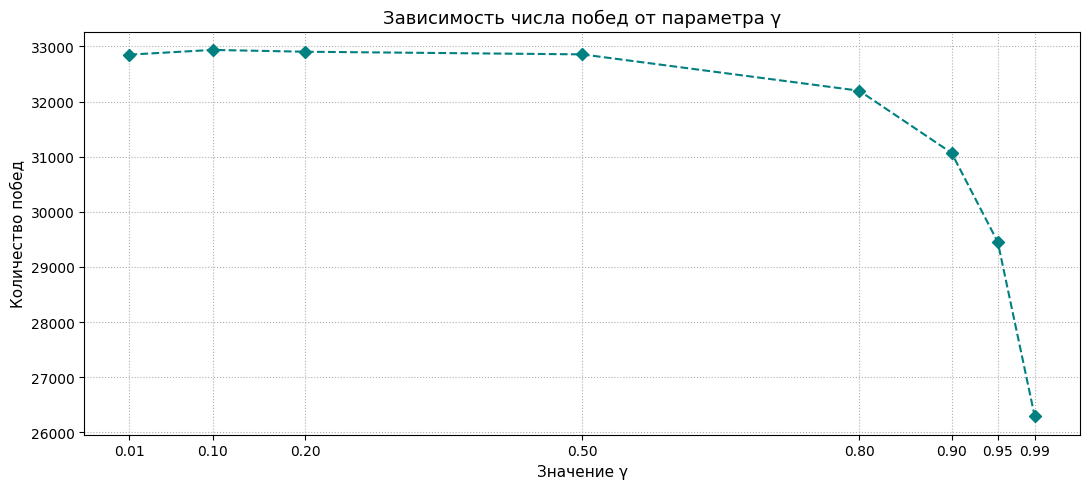

In [33]:
wins_per_gamma = wins_summary

plt.figure(figsize=(11, 5))
plt.plot(gamma_values, wins_per_gamma, color='teal', marker='D', linestyle='--')
plt.title('Зависимость числа побед от параметра γ', fontsize=13)
plt.xlabel('Значение γ', fontsize=11)
plt.ylabel('Количество побед', fontsize=11)
plt.xticks(gamma_values)
plt.grid(True, linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()

Определяет, сколько веса агент придаёт будущим наградам по сравнению с текущими.

Если gamma = 0, агент учитывает только немедленную награду.

Если gamma = 1, агент старается максимизировать долгосрочную выгоду.

## Learning Rate

Это скорость обучения агента, которая определяет, насколько сильно обновляется оценка Q-функции после каждого взаимодействия со средой.  



In [39]:
lr_values = [0.01, 0.1, 0.15,  0.2, 0.25, 0.5, 0.75, 0.8, 0.9,0.99]
total_wins_lr = []

for lr in lr_values:
    total_wins_lr.append(train_sarsa(
        gamma=0.8,
        lr_rate=lr,
       epsilon=0.1,
        total_games=40000))

100%|██████████| 40000/40000 [00:41<00:00, 969.55it/s]


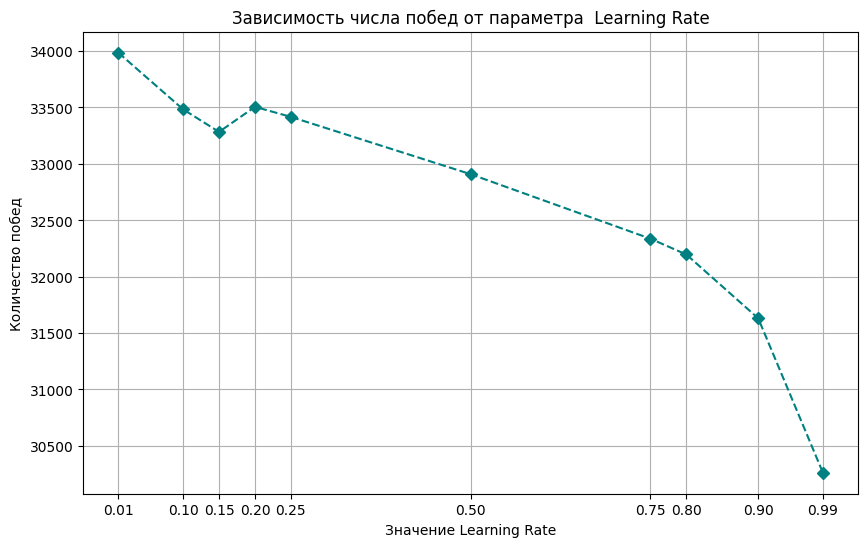

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(lr_values, total_wins_lr, color='teal', marker='D', linestyle='--')
plt.title('Зависимость числа побед от параметра  Learning Rate')
plt.xlabel('Значение Learning Rate')
plt.ylabel('Количество побед')
plt.xticks(lr_values)
plt.grid(True)
plt.show()

Управляет тем, насколько агент корректирует свои Q-значения на каждом шаге.

Низкое значение: обучение идёт медленно, но стабильно.

Высокое значение: обучение быстро, но может быть нестабильным.

## Epsilon

Это параметр, используемый в стратегиях ε-жадного выбора действий, который определяет вероятность случайного выбора действия (exploration) по сравнению с выбором действия на основе текущей оцененной Q-функции (exploitation).  



In [41]:
epsilon_decay_values = [0.01, 0.1, 0.15,  0.2, 0.25, 0.5, 0.75, 0.8, 0.9,0.99]
total_wins_epsi = []

for epsi in epsilon_decay_values:
    total_wins_epsi.append(train_sarsa(
        gamma=0.8,
        lr_rate=0.9,
       epsilon=epsi,
        total_games=40000))

100%|██████████| 40000/40000 [00:08<00:00, 4579.97it/s]


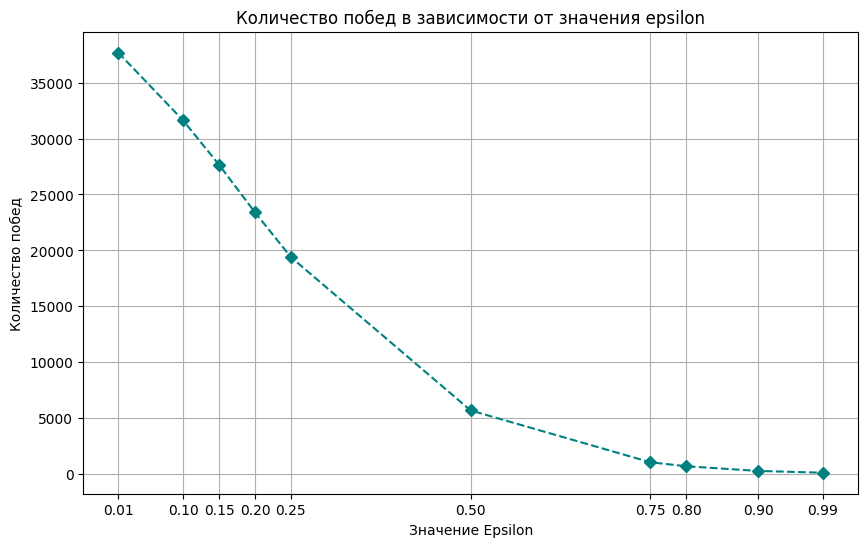

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_decay_values, total_wins_epsi, color='teal', marker='D', linestyle='--')
plt.title('Количество побед в зависимости от значения epsilon')
plt.xlabel('Значение Epsilon')
plt.ylabel('Количество побед')
plt.xticks(epsilon_decay_values)
plt.grid(True)
plt.show()

С вероятностью ε агент выбирает случайное действие (исследует).

С вероятностью 1 - ε — выбирает лучшее известное действие (эксплуатирует).


# Опциональная часть

Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

In [47]:
def choose_action(state, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(0, env.action_space.n) # Случайное действие (исследование)
    else:
        return np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist())) # Жадное действие (эксплуатация)

Softmax назначает вероятности действиям на основе их Q-значений. Чем выше Q-значение, тем больше вероятность выбора действия.

При большом τ — распределение почти равномерное (много случайности).

При маленьком τ — почти всегда выбирается действие с наибольшим Q (жадное поведение)

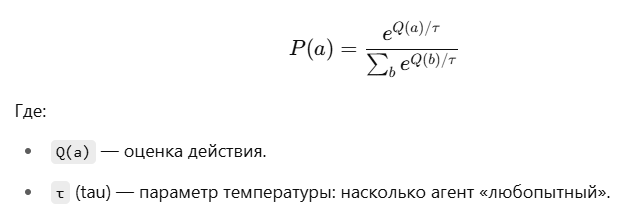

In [45]:
def choose_action_softmax(state, tau):
    preferences = Q[state, :] / tau
    exp_preferences = np.exp(preferences - np.max(preferences))
    probabilities = exp_preferences / np.sum(exp_preferences) # вероятность выбора действия
    return np.random.choice(env.action_space.n, p=probabilities)

100%|██████████| 10000/10000 [00:05<00:00, 1716.83it/s]


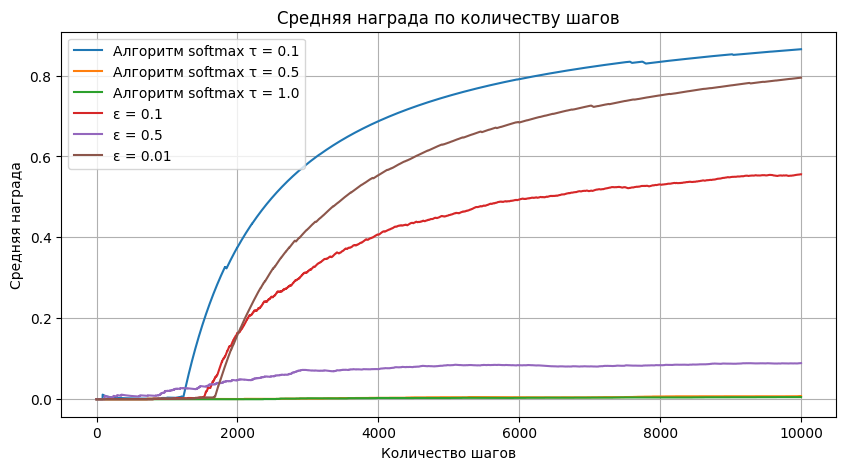

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

total_games = 10000
max_steps = 100
epsilon_values = [0.1, 0.5, 0.01]
tau_values = [0.1, 0.5, 1.0]
average_rewards = {epsilon: [] for epsilon in epsilon_values}
average_rewards_softmax = {tau: [] for tau in tau_values}



for epsilon in epsilon_values:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0
        action = choose_action(state,epsilon)

        for t in range(max_steps):
            state2, reward, done, info = env.step(action)
            action2 = choose_action(state2,epsilon)

            total_reward += reward
            learn(state, state2, reward, action, action2, done)
            state = state2
            action = action2

            if done:
                break

        total_rewards.append(total_reward)

        if game == 0:
            average_rewards[epsilon].append(total_rewards[-1])
        else:
            average_rewards[epsilon].append(
                (average_rewards[epsilon][-1] * game + total_rewards[-1]) / (game + 1)
            )



for tau in tau_values:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0
        action = choose_action_softmax(state, tau)

        for t in range(max_steps):
            state2, reward, done, info = env.step(action)
            action2 = choose_action_softmax(state2, tau)
            total_reward += reward
            learn(state, state2, reward, action, action2, done)
            state = state2
            action = action2

            if done:
                break

        total_rewards.append(total_reward)


        if game == 0:
            average_rewards_softmax[tau].append(total_rewards[-1])
        else:
            average_rewards_softmax[tau].append(
                (average_rewards_softmax[tau][-1] * game + total_rewards[-1]) / (game + 1)
            )




plt.figure(figsize=(10, 5))

for tau in tau_values:
    plt.plot(range(total_games), average_rewards_softmax[tau], label=f'Алгоритм softmax τ = {tau}')

for epsilon in epsilon_values:
    plt.plot(range(total_games), average_rewards[epsilon], label=f'ε = {epsilon}')

plt.title('Средняя награда по количеству шагов')
plt.xlabel('Количество шагов')
plt.ylabel('Средняя награда')
plt.legend()
plt.grid()
plt.show()


Выбирает действие, которое максимизирует верхнюю границу доверительного интервала для Q-значения. Это баланс между:

* Действиями с высокой средней наградой (exploitation).

* Действиями, которые мало исследовались (exploration).

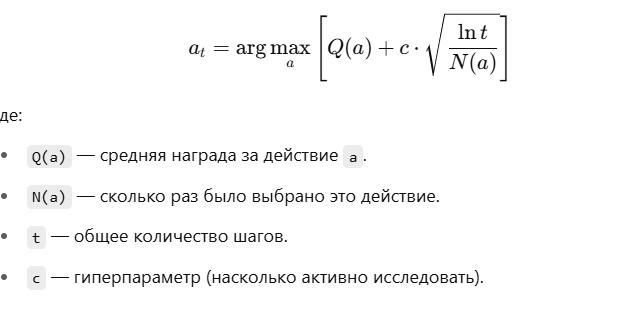

Действия с низким N(a) будут иметь больше «бонуса» и будут выбраны чаще.

Баланс между эксплуатацией (высокий Q) и исследованием (низкий N).

In [49]:
def ucb_action(state, Q, N, c=2.0):
    if np.any(N[state, :] == 0):
        return np.random.choice(np.where(N[state, :] == 0)[0])

    total_visits = np.sum(N[state, :])

    ucb_values = Q[state, :] + c * np.sqrt(np.log(total_visits) / N[state, :])

    return np.argmax(ucb_values)

100%|██████████| 10000/10000 [00:04<00:00, 2458.51it/s]


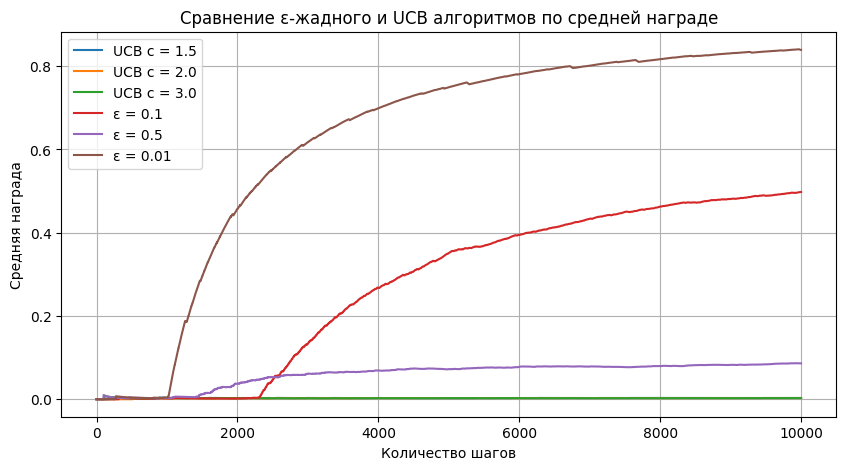

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


total_games = 10000
max_steps = 100
epsilon_values = [0.1, 0.5, 0.01]
c_values = [1.5, 2.0, 3.0]
average_rewards_ucb = {c: [] for c in c_values}
average_rewards_epsilon = {epsilon: [] for epsilon in epsilon_values}


for epsilon in epsilon_values:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0
        action = choose_action(state,epsilon)

        for t in range(max_steps):
            state2, reward, done, info = env.step(action)
            action2 = choose_action(state2,epsilon)

            total_reward += reward
            learn(state, state2, reward, action, action2, done)
            state = state2
            action = action2

            if done:
                break

        total_rewards.append(total_reward)

        if game == 0:
            average_rewards_epsilon[epsilon].append(total_rewards[-1])
        else:
            average_rewards_epsilon[epsilon].append(
                (average_rewards_epsilon[epsilon][-1] * game + total_rewards[-1]) / (game + 1)
            )



for c in c_values:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0

        for t in range(max_steps):
            action = ucb_action(state, Q, N, c)
            state2, reward, done, info = env.step(action)
            total_reward += reward


            N[state, action] += 1
            alpha = 1 / N[state, action]
            Q[state, action] += alpha * (reward - Q[state, action])

            state = state2

            if done:
                break

        total_rewards.append(total_reward)


        if game == 0:
            average_rewards_ucb[c].append(total_rewards[-1])
        else:
            average_rewards_ucb[c].append(
                (average_rewards_ucb[c][-1] * game + total_rewards[-1]) / (game + 1)
            )




plt.figure(figsize=(10, 5))


for c in c_values:
    plt.plot(range(total_games), average_rewards_ucb[c], label=f'UCB c = {c}')


for epsilon in epsilon_values:
    plt.plot(range(total_games), average_rewards_epsilon[epsilon], label=f'ε = {epsilon}')

plt.title('Сравнение ε-жадного и UCB алгоритмов по средней награде')
plt.xlabel('Количество шагов')
plt.ylabel('Средняя награда')
plt.legend()
plt.grid()
plt.show()


Инициализировать Q-значения завышенными числами (например, +100 вместо 0). Это заставляет агент активно исследовать все действия в начале, так как реальные награды окажутся меньше, и он будет постепенно "разочаровываться" в плохих действиях.

In [53]:
def optimistic_init(env, initial_value=100.0):
    return np.full((env.observation_space.n, env.action_space.n), initial_value) # инициализация Q таблицы с завышенными значениями

100%|██████████| 10000/10000 [00:24<00:00, 414.19it/s]


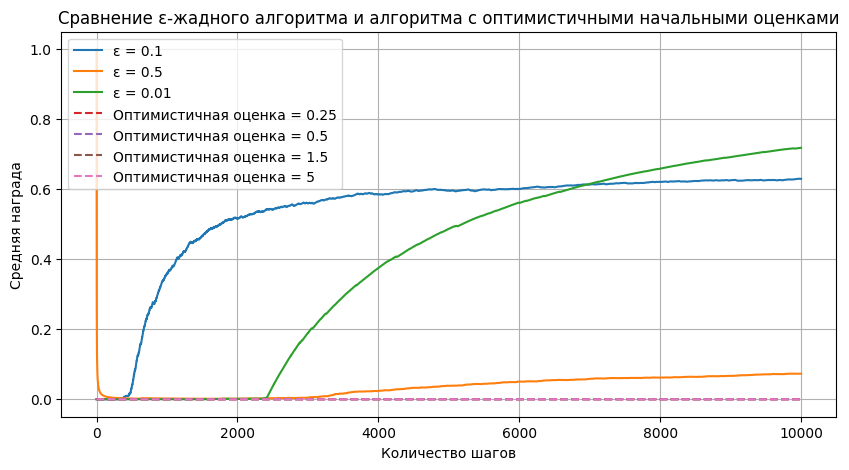

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


total_games = 10000
max_steps = 100
epsilon_values = [0.1, 0.5, 0.01]
optimistic_initial_values = [0.25, 0.5, 1.5, 5]
average_rewards_epsilon = {epsilon: [] for epsilon in epsilon_values}
average_rewards_optimal = {value: [] for value in optimistic_initial_values}


for epsilon in epsilon_values:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0
        action = choose_action(state, epsilon)

        for t in range(max_steps):
            state2, reward, done, info = env.step(action)
            action2 = choose_action(state2, epsilon)

            total_reward += reward
            learn(state, state2, reward, action, action2, done)
            state = state2
            action = action2

            if done:
                break

        total_rewards.append(total_reward)


        if game == 0:
            average_rewards_epsilon[epsilon].append(total_rewards[-1])
        else:
            average_rewards_epsilon[epsilon].append(
                (average_rewards_epsilon[epsilon][-1] * game + total_rewards[-1]) / (game + 1)
            )




for optimistic_initial_value in optimistic_initial_values:
    Q_optimal = np.full((env.observation_space.n, env.action_space.n), optimistic_initial_value)
    N_optimal = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards_optimal = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0

        for t in range(max_steps):
            action = np.argmax(Q_optimal[state, :])
            state2, reward, done, info = env.step(action)
            total_reward += reward


            N_optimal[state, action] += 1
            alpha = 1 / N_optimal[state, action]
            Q_optimal[state, action] += alpha * (reward - Q_optimal[state, action])

            state = state2

            if done:
                break

        total_rewards_optimal.append(total_reward)

        if game == 0:
            average_rewards_optimal[optimistic_initial_value].append(total_rewards_optimal[-1])
        else:
            average_rewards_optimal[optimistic_initial_value].append(
                (average_rewards_optimal[optimistic_initial_value][-1] * game + total_rewards_optimal[-1]) / (game + 1)
            )


plt.figure(figsize=(10, 5))

for epsilon in epsilon_values:
    plt.plot(range(total_games), average_rewards_epsilon[epsilon], label=f'ε = {epsilon}')

for optimistic_initial_value in optimistic_initial_values:
    plt.plot(range(total_games), average_rewards_optimal[optimistic_initial_value], label=f'Оптимистичная оценка = {optimistic_initial_value}', linestyle='--')

plt.title('Сравнение ε-жадного алгоритма и алгоритма с оптимистичными начальными оценками')
plt.xlabel('Количество шагов')
plt.ylabel('Средняя награда')
plt.legend()
plt.grid()
plt.show()


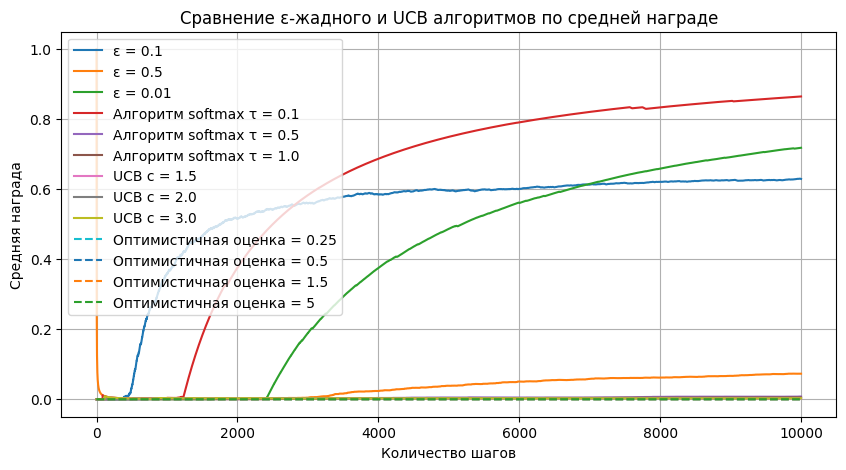

In [57]:
plt.figure(figsize=(10, 5))

for epsilon in epsilon_values:
    plt.plot(range(total_games), average_rewards_epsilon[epsilon], label=f'ε = {epsilon}')

for tau in tau_values:
    plt.plot(range(total_games), average_rewards_softmax[tau], label=f'Алгоритм softmax τ = {tau}')

for c in c_values:
    plt.plot(range(total_games), average_rewards_ucb[c], label=f'UCB c = {c}')

for optimistic_initial_value in optimistic_initial_values:
    plt.plot(range(total_games), average_rewards_optimal[optimistic_initial_value], label=f'Оптимистичная оценка = {optimistic_initial_value}', linestyle='--')

plt.title('Сравнение ε-жадного и UCB алгоритмов по средней награде')
plt.xlabel('Количество шагов')
plt.ylabel('Средняя награда')
plt.legend()
plt.grid()
plt.show()